In [63]:
### Note this is just a development script. 
### History matching is performed using batch jobs in ./hmatch

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle

import gpflow
import tensorflow as tf
from sklearn.metrics import r2_score


2025-02-06 15:52:21.385083: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 15:52:21.419737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738882341.444940   63102 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738882341.450940   63102 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 15:52:21.473190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Load PPE

In [2]:
#############################################
# user mods
#############################################
n_usamp = 50
n_psamp = 1000

pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]
npfts = len(pft_ids)
I_thresh=3
min_npsamp = 100

emulator_dir = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave1/emulators_pftlai_amax_lhc/'
out_dir = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/NROY/'


In [3]:
#############################################
# Setup
#############################################
# load obs data
obs_data = xr.open_dataset("CLMSP_amaxLAI_2003-2015_pftmean.nc")

# load PPE
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')
n_params = np.shape(params)[1]

dir='/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/'
ds = xr.open_dataset(dir+'ctsm6lhc_pftmean_1985-2023.nc')

# drop crashers
ds_clean = ds.where(ds['crashed'] != 1, drop=True)
ix = np.where(ds.crashed==1)[0]
params_clean = params.drop(ix-1)


In [5]:
def create_random_sample(n_usamp,n_psamp,param_names):

    u_sample = np.random.rand(n_usamp,41)
    p_sample = np.random.rand(n_psamp,15)

    pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                    'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                   'KCN','dleaf','xl','r_mort','fsr_pft']
    pftix=np.array([p in pft_params for p in param_names])
    
    sample=np.zeros([n_usamp*n_psamp,len(param_names)])
    sample[:,~pftix]= np.repeat(u_sample,n_psamp,axis=0)
    sample[:,pftix]= np.tile(p_sample,(n_usamp,1))

    return sample

In [6]:
def usample_NROY(I,n_usamp,n_psamp,min_npsamp,npft):
    # returns index of universal sets that have at least min_npsamp NROY sets for all PFTs
    uset_nroy = np.empty((n_usamp,npft))*np.NaN
    I_bool = np.where(I < 3, 1, 0)
    for p in range(npft):
        I_pft = I_bool[:,p].reshape((n_usamp,n_psamp))
        uset_nroy[:,p] = np.sum(I_pft,axis=1)>min_npsamp

    uset_idx = np.where(np.sum(uset_nroy,axis=1)==npft)[0]

    return uset_idx

### History Matching

In [7]:
#############################################
# History Matching
#############################################
# create random sample
sample = create_random_sample(n_usamp,n_psamp,params_clean.columns)


In [8]:
#############################################
# Calculate implausibility

set_I = np.empty((n_usamp*n_psamp,len(pft_ids)))*np.NaN

for p,pft in enumerate(pft_ids):

        loaded_emulator = tf.saved_model.load(emulator_dir + 'pft'+str(pft))
        y_pred, y_pred_var = loaded_emulator.predict(sample)

        m_mn = y_pred.numpy().flatten()
        m_var = y_pred_var.numpy().flatten()
        o_mn = obs_data['Mean'].sel(pft=pft).values
        o_var = obs_data['StDev'].sel(pft=pft).values**2
        
        # calculate implausibility
        set_I[:,p] = np.abs(o_mn-m_mn) / np.sqrt(o_var + m_var)


2025-02-06 15:53:35.232212: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
#############################################
#identify universal sets that have at least n_pftsets NROY sets for all PFTs 
uset_idx = usample_NROY(set_I,n_usamp,n_psamp,min_npsamp,npfts)

# select a coresponding PFT set for each PFT and Uset
I_bool = np.where(set_I < 3, True, False)

NROY_sample = np.empty((len(uset_idx),56,npfts))
s = sample.reshape(n_usamp,n_psamp,56)[uset_idx,:,:]
for p,pft in enumerate(pft_ids):
    indices=[]
    m = I_bool[:,p].reshape(n_usamp,n_psamp)[uset_idx,:]
    for row in m:
        nroy_ix = np.where(row)[0]
        pftset_ix = np.random.choice(nroy_ix)
        indices.append(pftset_ix)

    NROY_sample[:, :, p] = s[np.arange(len(uset_idx)), indices, :]


In [10]:
ds_nroy = xr.Dataset(
    {"nroy_paramsets": (["ens", "param", "pft"], NROY_sample)},
    coords={
        "ens": range(len(uset_idx)),
        "param": params.columns,
        "pft": pft_ids,},
)


In [13]:
idx = 101
filename = out_dir + "tmp.nc"
ds_nroy.to_netcdf(filename)

### Sanity check

In [11]:
pft_names = ['not veg','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES','BDMS','BDBS','C3G arctic','C3G','C4G']

In [12]:
# dates to match CLM-SP (per Peter Lawrence). 
lai = ds_clean.TLAI_pft_mean.sel(year=slice(2003,2015)).mean(dim='year').compute()

In [14]:
out_dir = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/NROY/'
filename = out_dir + "tmp.nc"
NROY_sample_loaded = xr.open_dataset(filename)

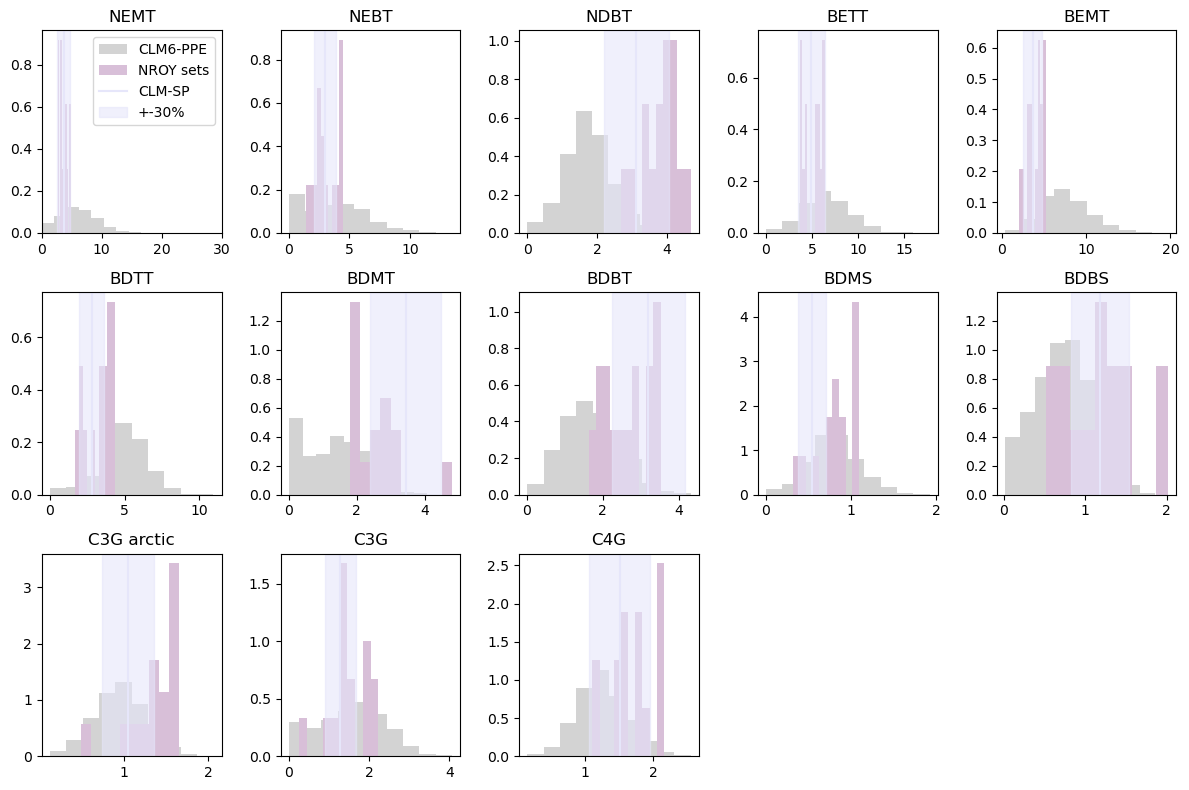

In [17]:

plt.figure(figsize=(12,8))
for p,pft in enumerate(pft_ids):

    samp = NROY_sample_loaded.nroy_paramsets.sel(pft=pft).values

    loaded_emulator = tf.saved_model.load('/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave1/emulators_pftlai_amax_lhc/pft'+str(pft))
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.subplot(3,5,p+1)
    plt.hist(lai.sel(pft=pft),color='lightgrey',density=True,label='CLM6-PPE')
    plt.hist(y_pred.numpy().flatten(),color='thistle',density=True,label='NROY sets')
    plt.axvline(obs_data['Mean'].sel(pft=pft),color='lavender',label='CLM-SP')
    plt.axvspan(obs_data['Mean'].sel(pft=pft)-3*obs_data['StDev'].sel(pft=pft),obs_data['Mean'].sel(pft=pft)+3*obs_data['StDev'].sel(pft=pft),color='lavender',alpha = 0.6,label='+-30%')
    plt.title(pft_names[pft])

    if p==0:
        plt.legend(facecolor='white',frameon=True)
        plt.xlim([0,30])
    
plt.tight_layout()
#plt.savefig('example_HM_30percent.png')